In [85]:
!pip install ta
!pip install yfinance

In [86]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import DataReader
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ta import add_all_ta_features
import yfinance as yf
from ta.utils import dropna
import plotly.express as px
from scipy.sparse import data
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [87]:
SHOW = False
VOL = ['WEI', 'IVDA', 'TKAT', 'CYRN', 'SLS',
       'XPON', 'HUSN', 'SNMP', 'GREE', 'USX']

In [88]:
# Sets up the start and End dates for the Stock Analysis
test_end_date = dt.now()
test_start_date = dt(test_end_date.year, test_end_date.month - 3, test_end_date.day)
train_end_date = dt(test_end_date.year, test_end_date.month - 3, test_end_date.day)
train_start_date = dt(test_end_date.year - 2, test_end_date.month, test_end_date.day)
print("Train Data dates : ", train_start_date, 'to', train_end_date)
print("Test Data dates : ", test_start_date, 'to', test_end_date)

start = dt(2012,4,6)
end = dt(2022,4,6) 

Train Data dates :  2020-04-29 00:00:00 to 2022-01-29 00:00:00
Test Data dates :  2022-01-29 00:00:00 to 2022-04-29 20:01:04.250981


In [89]:
def extract_data(stock_name):
  ''' '''
  # Creates a dataframe of the first stock using the Start and End dates
  stock = yf.download(stock_name,start,end)
  stock = dropna(stock)
  df = add_all_ta_features(
      stock, open="Open", high="High", low="Low", close="Close", volume="Volume")

  df = df.drop(["trend_psar_down","trend_psar_up"],axis = 1)
  df = df.dropna()
  return df


In [90]:
stock_chosen = 'AAPL'

# Calls function to data frame for stock passed
df = extract_data(stock_chosen)

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [91]:
# Defines Functions to create EDA visuals 
def daily_volatility(data, name):
  ''' '''

  dist = abs(data['Open'] - data['Close'])
  
  plt.plot(dist)
  plt.xticks(rotation=60)
  plt.xlabel('Dates')
  plt.ylabel('Distance in $ between Stock Open and Close')
  plt.title(f'{name} Daily Volatility Over Time')
  
  if SHOW:
      plt.show()


def volatility_vs_volume(data, name):
  ''' '''

  open_close = abs(data['Open'] - data['Close'])
  high_low = data['High'] - data['Low']

  avg_volatility = (open_close + high_low) / 2

  plt.scatter(avg_volatility, data['Volume'])
  plt.xlabel('Average Volatility')
  plt.ylabel('Stock Volume Traded')
  plt.title(f'Volatility in {name} vs Volume')

  if SHOW:
      plt.show()



def pair_plot(data, name, chosen=None):
  ''' '''
  selected = ['High', 'Low'] if chosen is None else chosen
  sns.pairplot(data=data, vars=selected, hue='Close')

  if SHOW:
      plt.show()


def box_plot(dataframes, names, chosen=None, scale=True):
    ''' '''

    selected = 'High' if chosen is None else chosen
    sc = StandardScaler()
    dataframes = [df[selected] for df in dataframes]
    dataframes  = [list(sc.fit_transform(np.array(lst).reshape(-1,1))) for lst in dataframes]

    maxLen = max(map(len, dataframes))

    for lst in dataframes:
      if len(lst) < maxLen:
        lst.extend([None] * (maxLen - len(lst)))

    df = pd.DataFrame()
    for data, name in zip(dataframes, names):
        df[name] = data

    df.dropna(inplace=True)

    for col in df.columns:
      df[col] = list(map(lambda x: x[0], df[col]))

    sns.boxplot(data=df)

    plt.xlabel('Stocks')
    plt.ylabel(f'Value for Statistic: {selected}')

    plt.title(f'Boxplot of Stocks Compared Using Statistic: {selected} ')

    if SHOW:
        plt.show()

In [92]:
# Creates a dataframe for a second stock for visualization
secondary_stock = VOL[1]
secondary_df = extract_data(secondary_stock)

stock_lst = [df, secondary_df]
name_lst = [stock_chosen, secondary_stock]

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


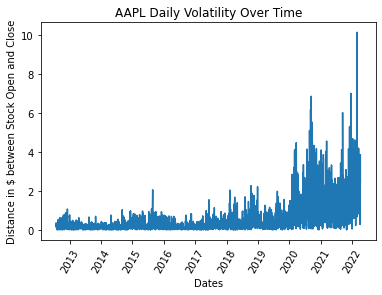

In [93]:
daily_volatility(stock_lst[0], name_lst[0])

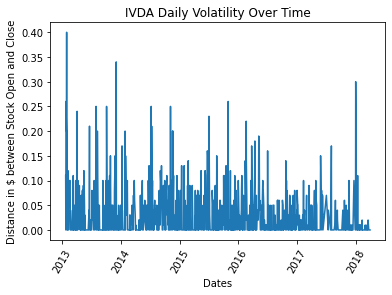

In [94]:
daily_volatility(stock_lst[1], name_lst[1])

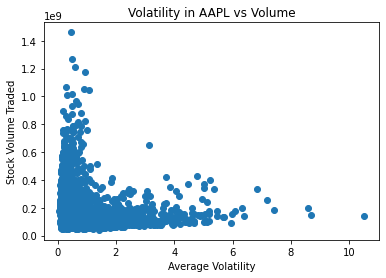

In [95]:
volatility_vs_volume(stock_lst[0], name_lst[0])

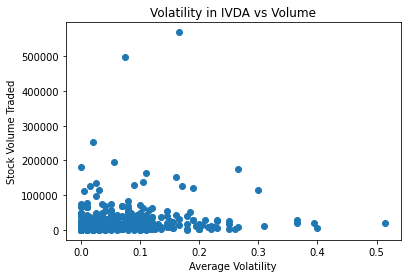

In [96]:
volatility_vs_volume(stock_lst[1], name_lst[1])

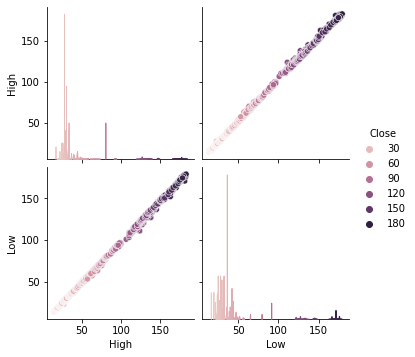

In [97]:
pair_plot(stock_lst[0], name_lst[0])

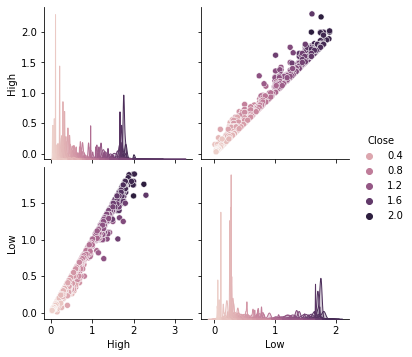

In [98]:
pair_plot(stock_lst[1], name_lst[1])

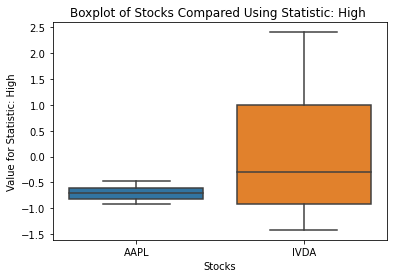

In [99]:
box_plot(stock_lst, name_lst, chosen='High')

In [100]:
# Creates the training and testing sets from the dataframe 
y = df['Close']
X = df.drop(columns=['Close'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [101]:
def get_variance(comp_count, train, test):
  ''' '''

  pca = PCA(n_components=comp_count)
  train = pca.fit_transform(train)
  test = pca.transform(test)

  return pca.explained_variance_ratio_, train, test, pca


In [102]:
# Finds optimal number of PCA components
components = 1
explained_variance = 0
while np.sum(explained_variance) < .95:

    explained_variance, X_train_fit, X_test_fit, pca = get_variance(components, 
                                                             X_train, X_test)
    
    components += 1


In [103]:
def make_df(X, y, var):
  ''' ''' 
  refit_data = pd.DataFrame(data=X, columns=[f'PC{num+1}' for num, p, 
                                          in enumerate(var)])
  refit_data['Closing Price'] = np.array(y) 
  return refit_data

In [104]:
# Creates Dataframe with all the Principal Components
refit_data = make_df(X_train_fit, y_train, explained_variance)

In [105]:
def cumulative_summation(var, sum_eigen, alpha=0.5):
  ''' '''

  plt.bar(range(0, len(var)), var,
          alpha=alpha, align='center', label='Individual explained variance')
  plt.step(range(0, len(sum_eigen)), sum_eigen, where='mid',
            label='Cumulative explained variance')
  plt.title('Cumulative Summation of Explained Variance')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

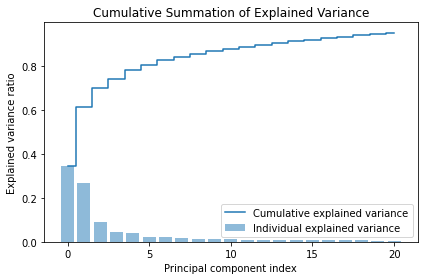

In [106]:
# Creates cumulative summation chart for all principal components
sum_eigenvalues = np.cumsum(explained_variance)
cumulative_summation(explained_variance, sum_eigenvalues)

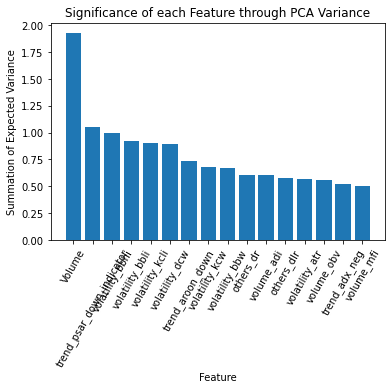

In [107]:
# Reformats the principal components into a usable dictionary
vals = np.array(pca.components_).T
pc_lst = [f'PC{num+1}' for num in range(len(vals.T))]
data = pd.DataFrame(vals, columns=pc_lst, index=X.columns)

# Creates an empty dictionary to store feature importance
feature_importance = {feature:0 for feature in X.columns}


# Populates dictionary with their principal component correspondants
for key in feature_importance.keys():
  feature_importance[key] = sum(data.loc[key])

# Creates an ordered list of the importance values from the dictionary
features_ordered = list(feature_importance.items())
features_ordered = sorted(features_ordered, key = lambda x: x[1])[::-1]

# Creates a list of bar heights and labels for each val above a threshold
thresh  = 0.5
height = [val for name, val in features_ordered if val >= thresh]
x = [name for name, val in features_ordered][:len(height)]

plt.bar(x, height)
plt.xticks(x, rotation=60)
plt.title('Significance of each Feature through PCA Variance')
plt.xlabel('Feature')
plt.ylabel('Summation of Expected Variance')
plt.show()

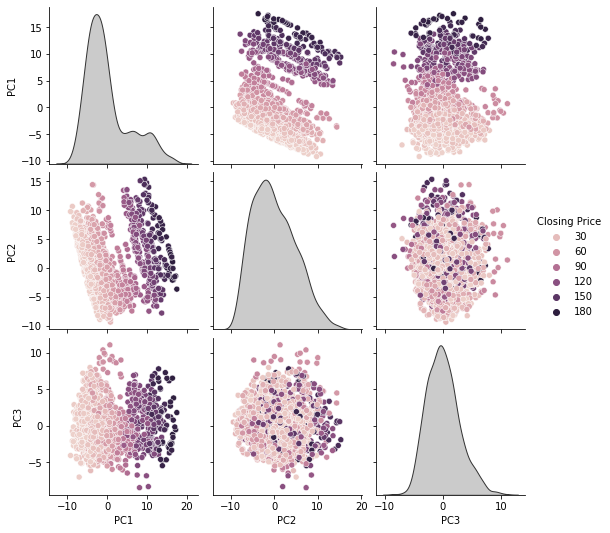

In [108]:
reduced_comp= 3

# To easily visualize the top 3 components are found
reduced_var, X_train_reduc, X_test_reduc, pca = get_variance(reduced_comp, 
                                                             X_train, X_test)
reduced_df = make_df(X_train_reduc, y_train, reduced_var)
# Creates Pairplot using the Dataframe
sum_eigenvalues = np.cumsum(reduced_var)

sns.pairplot(reduced_df, vars=reduced_df.columns[:-1], 
             hue='Closing Price', diag_kws=dict(color=".2", hue=None))
plt.show()

In [109]:
# define the lasso regression class
class LassoRegression() :

  # define the constructor and pass
  # learning rate, iterations i.e epochs and l1 penality for Lasso
  def __init__( self, lr, epochs, l1_penality ) :

      self.lr = lr
      self.epochs = epochs
      self.l1_penality = l1_penality
      
  # fit the model on training data
  def fit( self, X, Y ) :
      
      # no_of_training_examples, no_of_features
      self.m, self.n = X.shape
      
      # weight initialization
      self.W = np.zeros( self.n )
      
      self.b = 0
      self.X = X
      self.Y = Y
      
      # gradient descent learning
      for i in range( self.epochs ) :
          self.update_weights()
      return self

  # function to update weights in gradient descent
  def update_weights( self ) :

      Y_pred = self.predict( self.X )
      
      # calculate gradients
      dW = np.zeros( self.n )

      # add or subtract penalty depending upon positivity or negativity of weights
      for j in range( self.n ):
          if self.W[j] > 0 :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      + self.l1_penality ) / self.m
          else :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      - self.l1_penality ) / self.m

      db = - 2 * np.sum( self.Y - Y_pred ) / self.m
      
      # update weights
      self.W = self.W - self.lr * dW
      self.b = self.b - self.lr * db
      
      return self

  # predict the output
  def predict( self, X ) :
      return X.dot( self.W ) + self.b

In [110]:
def perform_lasso(X_train, X_test):
  # Model training
  model = LassoRegression( epochs = 1000, lr = 0.01, l1_penality = 500 )
  model.fit( X_train, y_train )

  # Prediction on test set
  y_pred = model.predict( X_test )

  return model.W, X_train

In [123]:
from seaborn.utils import axes_ticklabels_overlap
def bar_importance(coeff, X_train, feature_names, thresh):
  ''' ''' 

  # steps for feature importance
  feature_importance = np.std(X_train, 0)*np.array(coeff)
  
  above_threshold ={}
  # print feature name and their importance
  for name,importance in zip(feature_names,feature_importance):
      if abs(importance) >= thresh:
        above_threshold[name] = importance

  #create a dataframe containing feature name and their importance
  dff = pd.DataFrame([])
  dff['features'] = above_threshold.keys()
  dff['importance'] = above_threshold.values()

  d = dff.groupby(['features']).sum().sort_values('importance',ascending=False)
  
  # plot graph for feature importance
  d['importance'].plot.bar()
  return above_threshold

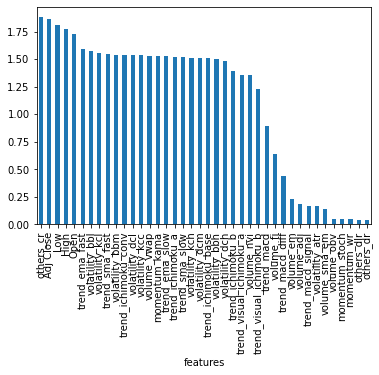

In [125]:
weight, X_train_refit = perform_lasso(X_train, X_test)
feature_names = X.columns

weight_thresh = 0.1
importance_dict = bar_importance(weight, 
                                 X_train_refit, feature_names, weight_thresh)
